# Wahana Cerdas Chatbot

### Install Library

In [1]:
import random
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import json
import nltk
import time
import re
import swifter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

from nltk.stem import WordNetLemmatizer
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

from urllib import request

import warnings
warnings.filterwarnings("ignore")

'''# Package sentence tokenizer
nltk.download('punkt') 
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')'''

"# Package sentence tokenizer\nnltk.download('punkt') \n# Package lemmatization\nnltk.download('wordnet')\n# Package multilingual wordnet data\nnltk.download('omw-1.4')"

### Data Acquisition

In [2]:
url = "https://raw.githubusercontent.com/Handepp/Tugas-Akhir-Chatbot/main/Dataset/Data%20Wahana.json"
request.urlretrieve(url, "Data%20Wahana.json")

('Data%20Wahana.json', <http.client.HTTPMessage at 0x226507ae6a0>)

In [3]:
# Importing the dataset
with open('Data%20Wahana.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [4]:
# Cetak data keseluruhan
data 

,patterns,tags
0,Siapa kamu?,Wardas.siapa
1,Kamu siapa?,Wardas.siapa
2,Ini apa?,Wardas.siapa
3,Kamu apa?,Wardas.siapa
4,Robot apakah kamu?,Wardas.siapa
...,...,...
186,Beritahu dayamu,wardas.Baterai
187,Beritahu nilai baterai mu,wardas.Baterai
188,Berapa lagi baterai yang kamu miliki,wardas.Baterai
189,Jumlah kapasitas bateraimu,wardas.Baterai


In [5]:
data.tags.value_counts()

Wardas.siapa          15
wardas.buruk          11
wardas.usia           10
wardas.hari            8
wardas.beban           7
wardas.tanggal         7
wardas.terimakasih     7
wardas.lokasi          7
wardas.Baterai         7
wardas.insaf           7
wardas.sapa            6
wardas.fast            6
wardas.medium          6
wardas.slow            6
wardas.jam             6
wardas.benar           5
wardas.hobby           5
wardas.bos             5
wardas.bantu           5
wardas.berpisah        5
wardas.hump            5
wardas.ngobrol         5
wardas.suhu            5
wardas.siap            5
wardas.baik            5
wardas.asal            5
wardas.sore            5
wardas.pagi            5
wardas.siang           5
wardas.malam           5
Name: tags, dtype: int64

In [6]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

30 classes ['Wardas.siapa', 'wardas.Baterai', 'wardas.asal', 'wardas.baik', 'wardas.bantu', 'wardas.beban', 'wardas.benar', 'wardas.berpisah', 'wardas.bos', 'wardas.buruk', 'wardas.fast', 'wardas.hari', 'wardas.hobby', 'wardas.hump', 'wardas.insaf', 'wardas.jam', 'wardas.lokasi', 'wardas.malam', 'wardas.medium', 'wardas.ngobrol', 'wardas.pagi', 'wardas.sapa', 'wardas.siang', 'wardas.siap', 'wardas.slow', 'wardas.sore', 'wardas.suhu', 'wardas.tanggal', 'wardas.terimakasih', 'wardas.usia']


### Preprocessing

In [7]:
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  #text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [9]:
key= "https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv"
request.urlretrieve(key, "key_norm.csv")
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


In [10]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

In [11]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [12]:
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = stemming(text)
  return text

In [13]:
%%time
data['patterns'] = data['patterns'].swifter.apply(text_preprocessing_process)

Pandas Apply:   0%|          | 0/191 [00:00<?, ?it/s]

CPU times: total: 3.44 s
Wall time: 3.63 s


In [13]:
data

,patterns,tags
0,siapa kamu,Wardas.siapa
1,kamu siapa,Wardas.siapa
2,ini apa,Wardas.siapa
3,kamu apa,Wardas.siapa
4,robot apakah kamu,Wardas.siapa
...,...,...
186,beritahu daya,wardas.Baterai
187,beritahu nilai baterai mu,wardas.Baterai
188,berapa lagi baterai yang kamu milik,wardas.Baterai
189,jumlah kapasitas baterai,wardas.Baterai


## LSTM

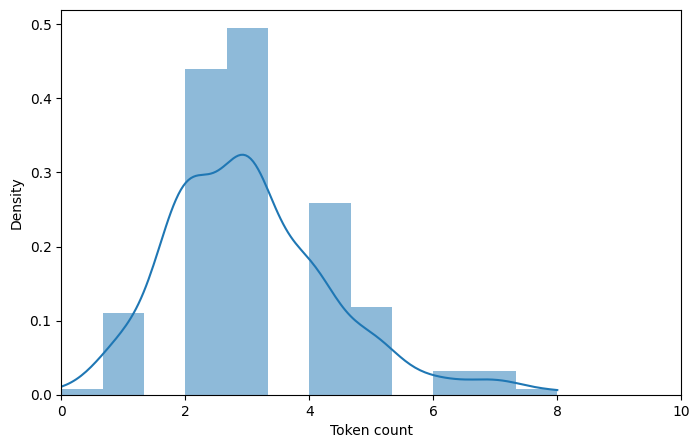

In [14]:
'''
Ada banyak cara untuk menentukan max_length
Intuisinya adalah kita tidak ingin memotong kalimat, atau terlalu banyak menambahkan padding (komputasi lebih lama)
Contoh ini, max_lenght ditentukan dari distribusi token pada dataset 
'''
token_lens = []

for text in data['patterns']:
    tokens = text.split()
    token_lens.append(len(tokens))

plt.figure(figsize=(8, 5))
sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 10]);
plt.xlabel('Token count');

In [15]:
MAX_SEQ_LENGTH = 9

In [ ]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[20, 1],
 [1, 20],
 [2, 6],
 [1, 6],
 [9, 24, 1],
 [9, 6, 2],
 [6, 1, 2],
 [93, 9, 2, 43, 6],
 [1, 53, 43, 6],
 [1, 54, 6],
 [94, 44, 1],
 [3, 54, 43, 6],
 [62, 45, 63],
 [64, 45, 63],
 [46, 45, 44],
 [65],
 [4, 65],
 [25, 1, 47],
 [11, 7, 25, 1, 55],
 [95, 66],
 [66],
 [47, 25],
 [9, 2, 48, 25],
 [25, 1, 48],
 [25, 48],
 [9, 67],
 [1, 2, 67],
 [1, 32, 53],
 [1, 32, 12, 26, 68, 17, 7, 69],
 [1, 96, 70],
 [1, 2, 32, 12, 26, 13, 49],
 [97, 1, 26, 13, 33],
 [1, 2, 33],
 [98, 1, 2, 33],
 [1, 99, 13, 33],
 [1, 26, 13, 33],
 [71, 1, 8, 50, 72],
 [18, 44, 100, 50, 53],
 [101, 43, 8, 50, 72],
 [1, 73, 74],
 [102, 8, 50, 18],
 [71, 1, 12, 74, 13, 18, 27],
 [1, 73, 8, 70],
 [20, 103],
 [20, 17, 75],
 [56, 54, 20],
 [1, 75, 104, 20],
 [76, 20, 1],
 [3, 28, 7, 10],
 [105, 1, 28, 106],
 [28, 7, 10],
 [7, 57, 28],
 [28, 7, 3],
 [24, 1, 56, 34],
 [6, 34],
 [107, 13, 34],
 [64, 45, 34],
 [11, 7, 34],
 [24, 1, 51],
 [24, 9, 77, 51],
 [24, 1, 77, 51],
 [108],
 [51, 44],
 [109, 78],
 [1, 78, 110, 14],
 

In [16]:
NUM_WORDS = 100       # Frekuensi kemunculan kata. Hanya num_words-1 yang akan disimpan pada dictionary. Berarti kata dengan kemunculan <=num_words tidak digunakan.
OOV_TOKEN = '<unk>'   # Token khusus untuk mengganti kata yang tidak terdaftar dalam dictionary.

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN, lower=True, split=' ')
tokenizer.fit_on_texts(data['patterns'])

# Tambahkan token padding untuk menyamakan ukuran dimensi embedding layer
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

WV_DICTIONARY = tokenizer.word_index

WV_DICTIONARY_SIZE = len(WV_DICTIONARY)
print(WV_DICTIONARY_SIZE) # Lihat kata unik pada dictionary yang dihasilkan

144


In [17]:
WV_DICTIONARY

{'<unk>': 1,
 'kamu': 2,
 'ini': 3,
 'wardas': 4,
 'berapa': 5,
 'cepat': 6,
 'apa': 7,
 'saya': 8,
 'jadi': 9,
 'robot': 10,
 'sekarang': 11,
 'beritahu': 12,
 'dapat': 13,
 'dengan': 14,
 'mana': 15,
 'selamat': 16,
 'hari': 17,
 'yang': 18,
 'baik': 19,
 'saat': 20,
 'siapa': 21,
 'tanggal': 22,
 'bebanberat': 23,
 'bawa': 24,
 'apakah': 25,
 'kapan': 26,
 'jawab': 27,
 'lagi': 28,
 'bantu': 29,
 'ruang': 30,
 'ubah': 31,
 'lambat': 32,
 'tidak': 33,
 'salah': 34,
 'hobi': 35,
 'halo': 36,
 'siang': 37,
 'pagi': 38,
 'sore': 39,
 'malam': 40,
 'suhu': 41,
 'lembap': 42,
 'baterai': 43,
 'untuk': 44,
 'diri': 45,
 'tentang': 46,
 'bicara': 47,
 'cipta': 48,
 'buat': 49,
 'benar': 50,
 'lebih': 51,
 'siap': 52,
 'sedangmedium': 53,
 'guna': 54,
 'itu': 55,
 'ada': 56,
 'milik': 57,
 'butuh': 58,
 'ayo': 59,
 'terimakasih': 60,
 'jam': 61,
 'saja': 62,
 'kata': 63,
 'anda': 64,
 'cerita': 65,
 'umur': 66,
 'usia': 67,
 'bodoh': 68,
 'tanya': 69,
 'sampai': 70,
 'pintar': 71,
 'moga': 7

In [18]:
# Proses mengubah token hasil tokenisasi menjadi urutan bilangan int berdasarkan index dictionary.
data_seq = tokenizer.texts_to_sequences(data['patterns'])

In [19]:
PADDING = 'post'        # Berikan padding untuk setiap sequences. Terdapat dua pilihan dalam melakukan padding 'pre' or 'post'.
TRUNCATING = 'post'     # Menghapus token dari sequences yang lebih besar dari max_lenght. Terdapat dua pilihan dalam melakukan truncanting 'pre' or 'post'.

data_pad = pad_sequences(data_seq, maxlen=MAX_SEQ_LENGTH, padding=PADDING, truncating=TRUNCATING)

In [20]:
# Encoding the outputs 
le = LabelEncoder()
y = le.fit_transform(data['tags'])
print(y) #Label Encodings

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 29 29 29 29 29 29 29 29 29
 29  9  9  9  9  9  9  9  9  9  9  9 14 14 14 14 14 14 14  8  8  8  8  8
  4  4  4  4  4 12 12 12 12 12 23 23 23 23 23  2  2  2  2  2  6  6  6  6
  6 19 19 19 19 19 21 21 21 21 21 21 22 22 22 22 22 20 20 20 20 20 25 25
 25 25 25 17 17 17 17 17  3  3  3  3  3 16 16 16 16 16 16 16 26 26 26 26
 26 13 13 13 13 13 28 28 28 28 28 28 28  7  7  7  7  7 15 15 15 15 15 15
 11 11 11 11 11 11 11 11 27 27 27 27 27 27 27  5  5  5  5  5  5  5 24 24
 24 24 24 24 18 18 18 18 18 18 10 10 10 10 10 10  1  1  1  1  1  1  1]


In [21]:
# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(data_pad, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((152, 9), (39, 9), (152,), (39,))

In [22]:
'''
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

model_LSTM = Sequential()
model_LSTM.add(Embedding(                                           # Buat embedding layer yang menerima panjang dictionary hasil Tokenisasi
    input_dim = WV_DICTIONARY_SIZE,
    input_length = MAX_SEQ_LENGTH,
    output_dim = 100))      
model_LSTM.add(LSTM(100))                                            # Tambahkan satu layer LSTM
model_LSTM.add(Dropout(0.5))                             
model_LSTM.add(Dense(30, activation='softmax'))

In [23]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9, 100)            14400     
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 30)                3030      
                                                                 
Total params: 97,830
Trainable params: 97,830
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile model
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
%%time

EPOCH = 400
BATCH_SIZE = 16

history_LSTM = model_LSTM.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/400
10/10 [==============================] - 4s 50ms/step - loss: 3.4016 - accuracy: 0.0132 - val_loss: 3.4035 - val_accuracy: 0.0769
Epoch 2/400
10/10 [==============================] - 0s 11ms/step - loss: 3.3923 - accuracy: 0.0526 - val_loss: 3.4009 - val_accuracy: 0.1026
Epoch 3/400
10/10 [==============================] - 0s 11ms/step - loss: 3.3763 - accuracy: 0.0658 - val_loss: 3.4008 - val_accuracy: 0.1026
Epoch 4/400
10/10 [==============================] - 0s 11ms/step - loss: 3.3637 - accuracy: 0.0855 - val_loss: 3.3961 - val_accuracy: 0.1026
Epoch 5/400
10/10 [==============================] - 0s 11ms/step - loss: 3.3381 - accuracy: 0.0855 - val_loss: 3.3917 - val_accuracy: 0.1026
Epoch 6/400
10/10 [==============================] - 0s 10ms/step - loss: 3.3150 - accuracy: 0.0855 - val_loss: 3.3801 - val_accuracy: 0.1026
Epoch 7/400
10/10 [==============================] - 0s 11ms/step - loss: 3.2510 - accuracy: 0.0921 - val_loss: 3.3172 - val_accuracy: 0.1282
Epoch 

In [ ]:
# Apply padding 
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[  0   0   0 ...   0  20   1]
 [  0   0   0 ...   0   1  20]
 [  0   0   0 ...   0   2   6]
 ...
 [  0   0   4 ...  17   1  56]
 [  0   0   0 ...  90 142  42]
 [  0   4  92 ...  17   1  76]]


In [ ]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

8


In [ ]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  142
output length:  30


In [ ]:
print(tokenizer.word_index)

{'kamu': 1, 'ini': 2, 'wardas': 3, 'berapa': 4, 'cepat': 5, 'apa': 6, 'saya': 7, 'jadi': 8, 'robot': 9, 'sekarang': 10, 'beritahu': 11, 'dapat': 12, 'dengan': 13, 'mana': 14, 'selamat': 15, 'hari': 16, 'yang': 17, 'baik': 18, 'saat': 19, 'siapa': 20, 'tanggal': 21, 'bebanberat': 22, 'bawa': 23, 'apakah': 24, 'kapan': 25, 'jawab': 26, 'lagi': 27, 'bantu': 28, 'ruang': 29, 'ubah': 30, 'lambat': 31, 'tidak': 32, 'salah': 33, 'hobi': 34, 'halo': 35, 'siang': 36, 'pagi': 37, 'sore': 38, 'malam': 39, 'suhu': 40, 'lembap': 41, 'baterai': 42, 'untuk': 43, 'diri': 44, 'tentang': 45, 'bicara': 46, 'cipta': 47, 'buat': 48, 'benar': 49, 'lebih': 50, 'siap': 51, 'sedangmedium': 52, 'guna': 53, 'itu': 54, 'ada': 55, 'milik': 56, 'butuh': 57, 'ayo': 58, 'terimakasih': 59, 'jam': 60, 'saja': 61, 'kata': 62, 'anda': 63, 'cerita': 64, 'umur': 65, 'usia': 66, 'bodoh': 67, 'tanya': 68, 'sampai': 69, 'pintar': 70, 'moga': 71, 'pintarbaik': 72, 'harus': 73, 'ajar': 74, 'kembang': 75, 'punya': 76, 'sudah': 7

In [ ]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,50)(i) # Layer Embedding
x = LSTM(50, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
# Menampilkan Parameter Model
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 embedding (Embedding)       (None, 8, 50)             7150      
                                                                 
 lstm (LSTM)                 (None, 8, 50)             20200     
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 30)                12030     
                                                                 
Total params: 39,380
Trainable params: 39,380
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model (Latih model data sampai 400 kali)
train = model.fit(x_train, y_train, epochs=50, validation_split = 0.25)

Epoch 1/50
5/5 [==============================] - 3s 109ms/step - loss: 3.3988 - accuracy: 0.0280 - val_loss: 3.4183 - val_accuracy: 0.0000e+00
Epoch 2/50
5/5 [==============================] - 0s 15ms/step - loss: 3.3807 - accuracy: 0.1119 - val_loss: 3.4501 - val_accuracy: 0.0000e+00
Epoch 3/50
5/5 [==============================] - 0s 33ms/step - loss: 3.3561 - accuracy: 0.1119 - val_loss: 3.5087 - val_accuracy: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 3.3225 - accuracy: 0.1189 - val_loss: 3.6214 - val_accuracy: 0.0000e+00
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 3.2700 - accuracy: 0.1049 - val_loss: 3.8445 - val_accuracy: 0.0000e+00
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 3.1927 - accuracy: 0.1049 - val_loss: 4.2890 - val_accuracy: 0.0000e+00
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 3.1202 - accuracy: 0.1049 - val_loss: 5.0729 - val_accuracy: 0.0000e+0